## Lets Create a Price Adjuster

So, we have an idea, to simplify the work required to find nearby rentals that are
similar to the new rentals that I am adding and attempt to create a price calculator
that will provide me with the best expected price from those results.   

With that in mind lets start the process.  

### Setting up

So the first thing that we are going to do is setup our imports, so that we have all the tools
we are going to work with loaded (don't need to load later)

In [1]:
import pandas as pd
import numpy as np

from pprint import pprint

pd.options.display.max_rows = 4000
pd.options.mode.chained_assignment = None

### First Analyze the Data

So to start lets look over the data that we have received, first we will
need to load the data so that we can manipulate it later. 

In [2]:
data = pd.read_csv('../data/listing.csv')

At this point lets do a quick check of the data for row count and even first row to sample the data.  

In [3]:
print('Row Count: {}'.format(len(data)))
print('-'*20)
print(data.iloc[0])

Row Count: 2505
--------------------
id                                                                           12622842
listing_url                                     https://www.airbnb.com/rooms/12622842
scrape_id                                                              20160516142622
last_searched                                                              2016-05-16
last_scraped                                                               2016-05-17
name                                              Single Bed in a Cozy Denver Home!!!
summary                             My house is minutes away from downtown Denver ...
space                               In this cozy and simple room there is a twin b...
description                         My house is minutes away from downtown Denver ...
experiences_offered                                                              none
neighborhood_overview               Denver is quite the city with many places wort...
notes            

So the column that we are trying to determine for future entries is the price column.  Knowing that
we need to determine which other columns we can use to create features.  

Since all modeling requires that the data be represented as a numeric value, and since we are limited
on time, we are going to focus only on columns that already have a defined numeric representation.  

So we are going to ignore columns that are:  

* Text
 * URL
 * Short/Long Descriptions
* Date
* Lat/Long

That leaves use with a number of columns still, but for our first attempt lets just use a few columns:  

* bathrooms
* bedrooms
* beds
* accommodates
* price

In [4]:
columns = ['bathrooms', 'bedrooms', 'beds', 'accommodates', 'price']
data.dropna(axis=0, how='any', subset=columns, inplace=True)

subset = data[columns]
pprint(subset.dtypes)

bathrooms       float64
bedrooms        float64
beds            float64
accommodates    float64
price            object
dtype: object


So looking over the columns, it seems that the price column is the only one that is not already
in a numeric type, so lets start by looking at the price value in the first 10 rows to determine
what the data looks like.  

In [5]:
print(subset['price'][:5])

0     $35.00
1    $129.00
2     $99.00
3     $70.00
4     $50.00
Name: price, dtype: object


Ok, so it looks like it is formatted with a `$` in front, so lets convert the column value and
translate it to a numeric type.  

In [6]:
data['price'] = data['price'].str.replace('$', '')
data['price'] = data['price'].str.replace(',', '')
data['price'] = data['price'].astype(float)

subset = data[columns]
print(subset['price'][:5])
print(subset.dtypes)

0     35.0
1    129.0
2     99.0
3     70.0
4     50.0
Name: price, dtype: float64
bathrooms       float64
bedrooms        float64
beds            float64
accommodates    float64
price           float64
dtype: object


---

### Modeling

Alright so at this point we have some data to work with and have it formatted in a fashion that we
can start creating some models.  

For our first model we are going to go with a simple regression model using **K-Nearest Neighbors**

This algorithm simply takes the supplied feature vector and finds the _k_ closest examples to the
selected vector (nearest neighbors).  In the case of regression it will take the values from each
of the _k_ neighbors and calculate the average.  

For our setup we are going to use the Euclidean Distance to determine how closely related
two vectors are.   

#### Euclidean Formula

The formula is defined below.  

p - current vector
q - comparing vector

\begin{equation*}
distance = \sqrt{(p_1-q_1)^2 + (p_2-q_2)^2 + \cdots + (p_n-q_n)^2}
\end{equation*}

or shorter form

\begin{equation*}
distance = \sqrt{\sum_{i=1}^{n}(p_i-q_i)^2}
\end{equation*}

So now lets go through an example of how we can use this to calculate the distance.  

In this example we are going to use only two of the features (bathrooms, bedrooms) and compare
the distance for the first two rows.  

In [7]:
features = ['bathrooms', 'bedrooms']
p = subset[features].iloc[0]
q = subset[features].iloc[1]
print('p')
print('-'*20)
print(p)
print('q')
print('-'*20)
print(q)

p
--------------------
bathrooms    1.0
bedrooms     1.0
Name: 0, dtype: float64
q
--------------------
bathrooms    1.0
bedrooms     3.0
Name: 1, dtype: float64


In [8]:
distance = np.sqrt(np.sum(np.square(p-q)))
print(distance)

2.0


So lets check our math to make sure this is correct.  

\begin{equation*}
2.0 = \sqrt{(1-1)^2 + (1-3)^2}
\end{equation*}

Looks good to me, this means that the distance between the first two entries is 2.0.  However, there is
problem with using the raw values when calculating the distance, features with larger values will dwarf
features with smaller values.  So lets start by normalizing our data. 

#### Normalizing

To normalize the data we want to convert it in such as way that the distance difference for bathrooms
will have a similar effect as the distance difference for bedrooms.  

To accomplish this we will take each of our entries and convert them to be a standard normalized distribution
which basically states that the mean will be treated as a 0 and one standard deviation away is (1, -1).  

In [9]:
def normalize(ds):
    original_price = ds['price']
    ds = (ds - ds.mean()) / ds.std()
    ds['price'] = original_price
    return ds
    
subset = normalize(subset)
subset.head(5)

,bathrooms,bedrooms,beds,accommodates,price
0,-0.559854,-0.542877,-0.653516,-1.174870,35.0
1,-0.559854,1.608295,0.056624,0.582830,129.0
2,-0.559854,-0.542877,-0.653516,-0.735445,99.0
3,-0.559854,-0.542877,0.056624,-0.296020,70.0
4,-0.559854,-0.542877,-0.653516,-0.735445,50.0


Lets go ahead and calculate the distance between our selected entry and the rest of the dataset.  

*Note*: It is import to note that when running the comparision of one entry to another we must
remove the entry for the check set, otherwise we could put ourselves into a situation where
the nearest neighbor could be itself, and in a scenario where `k=1` you would get a perfect 
solution that doesn't predict anything.

In [10]:
p = subset.iloc[0]
subset = subset[1:]
subset['distance'] = subset[features].apply(lambda q: np.sqrt(np.sum(np.square(p[features]-q))), axis=1)
print(subset['distance'].value_counts().head(5))
print(subset.iloc[-1])

0.000000    1264
1.075586     343
1.832630     179
0.741897     110
2.613272      96
Name: distance, dtype: int64
bathrooms        0.923941
bedrooms        -0.542877
beds             0.056624
accommodates    -1.174870
price           75.000000
distance         1.483795
Name: 2504, dtype: float64


So it looks like we actually have 1264 neighbors... that are the closest (as close as possible)
and if we wanted to select _k_ of them, we would need to make sure that we are `unbiased` in our
selection, so lets sort the distance values (and randomize them when they are close).  

After doing that we can select the top _k_ rows (in this case lets go with the 5 closest neighbors). 

In [11]:
random_order = np.random.permutation(len(subset))
subset = subset.loc[random_order]
#subset.sort_values(['distance'], inplace=True)
neighbors = subset[:5]
print(subset.iloc[-1])

bathrooms        -0.559854
bedrooms         -1.618463
beds              0.056624
accommodates      0.143405
price           179.000000
distance          1.075586
Name: 2159, dtype: float64


Now that we have our neighbors we can compare the mean price of the neighbors
and use that to determine how close we are to the actual price of our selected
entry.  


In [12]:
mean_price = neighbors['price'].mean()
p_price = p['price']
print(f'estimated price: {mean_price}')
print(f'actual price: {p_price}')

estimated price: 56.4
actual price: 35.0


So we have an estimated price and an actual price that we generated using the 5 nearest neighbors.  
Now we need to take these values and calculate the error that we introduced.  

This can be done by using a function named the _Mean Absolute Error_ or (MAE).  The MAE function
is defined below.  

\begin{equation*}
error = \dfrac{|g_1 - a_1| + |g_2 - a_2| + \cdots + |g_n - a_n|}{n}
\end{equation*}

or the simplier form

\begin{equation*}
error = \dfrac{\sum_{i=1}^{n}{|(g_i - a_i)|}}{n}
\end{equation*}

In our case n = 1 so we can simplify it to

\begin{equation*}
error = |m - p|
\end{equation*}


In [13]:
error = np.abs(mean_price - p_price)
print(error)

21.4


Now there is one thing that we will want to do when calculating an error, we actually want values
that are farther from the true value to be penalized more.  This can be accomplished using the
MSE or _Mean Squared Error_.  

\begin{equation*}
error = \dfrac{\sum_{i=1}^{n}{(g_i - a_i)^2}}{n}
\end{equation*}

Of course this means that the value losses its representation and we can no longer consider it to 
represent a dollar, although that can be fixed just by taking the sqrt of the MSE: RMSE. 

\begin{equation*}
error = \sqrt{\dfrac{\sum_{i=1}^{n}{(g_i - a_i)^2}}{n}}
\end{equation*}


---

#### Sklearn implementation

At this point we have gone over our own version of the *K Nearest Neighbor* using the
Euclidean distance formula and determined the error.  These algorithms and functions 
have actually all been created before and optimized by taking advantage of C.  
So instead of re-inventing the wheel, lets see how we can quickly create a model 
using the sklearn framework.  

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

subset = data[columns]
subset = normalize(subset)
p = subset.iloc[0]
subset = subset[1:]

model = KNeighborsRegressor(algorithm='brute', n_neighbors=5)
# fit our model (calculate the distances), specify the value to use for regression
model.fit(subset[features], subset['price'])
# test our model out 
#  Note: we are reshaping the input so that as per sklearn's requirement for single samples
predictions = model.predict(p[features].values.reshape(1, -1))
error = mean_squared_error([p['price']], predictions)
print(error)

772.84


Now this shows the MSE for a single sample, the top one.  What we really want to do is to 
take a subset of our data and split it into two groups, training data and test data.  

The rule of thumb for separating this data is to use ~70% as the training data, and the
other ~30% as the testing data.  

So here let's create our train and testing data. 

In [15]:
from sklearn.utils import shuffle
from math import floor

subset = data[columns]
subset = normalize(subset)
subset = shuffle(subset)

data_size = len(subset)
split_index = floor(data_size*.7)
training_set = subset[:split_index]
test_set = subset[split_index:]

In [16]:
training_set.head(5)

,bathrooms,bedrooms,beds,accommodates,price
920,-0.559854,-0.542877,0.766765,0.143405,56.0
1127,0.923941,-0.542877,-0.653516,-0.735445,45.0
1910,-0.559854,-0.542877,-0.653516,-0.735445,120.0
1007,-0.559854,-1.618463,-0.653516,-0.735445,95.0
1814,0.182044,0.532709,0.056624,0.143405,125.0


Now lets re-run our above code using the training_set and test_set.  

In [17]:
model = KNeighborsRegressor(algorithm='brute', n_neighbors=5)
# fit our model (calculate the distances), specify the value to use for regression
model.fit(training_set[features], training_set['price'])
# test our model out 
#  Note: we are reshaping the input so that as per sklearn's requirement for single samples
predictions = model.predict(test_set[features])
error = mean_squared_error(test_set['price'], predictions)
print(error)

18243.030137


So we have our error on our testing and training set, lets create a function that we can use
to quickly run this. 

In [18]:
def test_model(features, k):
    model = KNeighborsRegressor(algorithm='brute', n_neighbors=k)
    model.fit(training_set[features], training_set['price'])
    predictions = model.predict(test_set[features])
    error = mean_squared_error(test_set['price'], predictions)
    return error

At this point we have a way to adjust our features, as well as our single hyperparameter.  Lets
try it out by using the same features that we have been using (bedrooms, bathrooms) but by adjusting
the _k_ value (from 1 to 10).   

In [19]:
error_values = []
k_range = list(range(1, 11))
for k in k_range:
    error_values.append(test_model(features, k))
pprint(error_values)

[20329.201369863014,
 17650.270547945205,
 17111.428158295283,
 18794.740839041096,
 18243.030136986297,
 18430.443074581432,
 18642.361671792005,
 18318.549379280823,
 17950.616979536615,
 17786.915479452055]


While this might be a nice list... it isn't the best for us to quickly see how well our model is working
with the different hyperparameter value, so lets try to visual the results.  

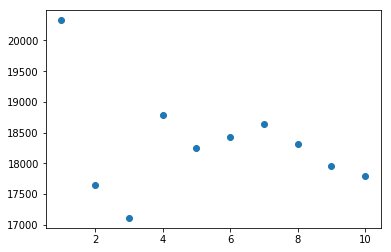

In [20]:
import matplotlib.pyplot as plt

plt.scatter(k_range, error_values)
plt.show()

Alright, so right now it looks like the data is still getting better when we get to the point of
using `k=10`.  

Lets try it with more k values, from 1 to 40 this time.  

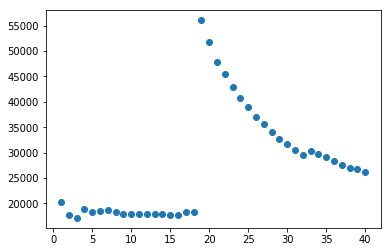

In [21]:
error_values = []
k_range = list(range(1, 41))
for k in k_range:
    error_values.append(test_model(features, k))

plt.scatter(k_range, error_values)
plt.show()

One thing that happens often with K Nearest Neighbors as it search the hyperparameter space is that you
can get to a low point and then start going the wrong way, so you will want to watch out for that.  

Lets go ahead and create another function, one that does a k value search but allows you to use different
features and just returns the best k value and error it sees.  

In [22]:
def k_search(features, max_k=40):
    min_result = None
    for k in range(1, max_k+1):
        error = test_model(features, k)
        if min_result is None or error < min_result[1]:
            min_result = k, error, np.sqrt(error)
    return min_result

Now lets run some experiments with a few different feature sets.  

* `['bathrooms', 'bedrooms']`
* `['accomodates']`
* `['accomodates', 'beds']`
* `['accomodates', 'bathrooms', 'bedrooms']`
* `['accomodates', 'beds', 'bathrooms', 'bedrooms']`

In [23]:
feature_sets = [
    ['bathrooms', 'bedrooms'],
    ['accommodates'],
    ['accommodates', 'beds'],
    ['accommodates', 'bathrooms', 'bedrooms'],
    ['accommodates', 'beds', 'bathrooms', 'bedrooms'],
]

error_values = []
for fs in feature_sets:
    error_values.append(k_search(fs))
    
pprint(error_values)

[(3, 17111.428158295283, 130.81065766326259),
 (11, 16495.997815011888, 128.43674635793249),
 (14, 17131.573511322335, 130.88763696897556),
 (31, 17363.811024475079, 131.77181422624142),
 (9, 16891.208997124973, 129.96618405233329)]


---

### Other Models

Now this is just an example of one model, there are others that we can use as well including,
but not limited to:  

* Linear Regression
* SVM (Support Vector Machines)
* Random Forest

With that in mind, lets quickly create a model that uses the sklearn random forest to see 
how it compares to our K Nearest Neighbor.  

In [30]:
from sklearn.ensemble import RandomForestRegressor

def forest_test(features, trees):
    model = RandomForestRegressor(criterion='mse', n_estimators=trees)
    model.fit(training_set[features], training_set['price'])
    predictions = model.predict(test_set[features])
    error = mean_squared_error(test_set['price'], predictions)
    return error

def forest_search(features, max_trees=200):
    min_result = None
    for t in range(10, max_trees+1, 10):
        error = test_model(features, t)
        if min_result is None or error < min_result[1]:
            min_result = t, error, np.sqrt(error)
    return min_result

In [31]:
error_values = []
for fs in feature_sets:
    error_values.append(forest_search(fs))
    
pprint(error_values)

[(10, 17786.915479452055, 133.36759531254981),
 (10, 16575.46516438356, 128.74573843193241),
 (20, 17335.7035, 131.66511876727259),
 (70, 17372.320303326811, 131.80409820383738),
 (10, 17069.930684931503, 130.65194481878754)]
